# Seawat Model

### Import Statements

In [1]:
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import flopy.utils.binaryfile as bf
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys
import datetime
import math
from sklearn.metrics import mean_squared_error as mse
import flopy.mt3d as mt3

%matplotlib inline

### Print Versions

In [2]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.14.3
matplotlib version: 2.1.1
flopy version: 3.2.10


### Setup folder where modflow-files are located

In [3]:
workspace = os.path.join('mf-data-seawat-density')
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)
modelname = 'model'
exe_name = 'mf2005'

if platform.system() == 'Windows':
    exe_name += '.exe'

### Setup Seawat Model

RCT: setting srconc for component 2 to zero, kwarg name srconc2
RCT: setting sp2 for component 2 to zero, kwarg name sp22
RCT: setting rc1 for component 2 to zero, kwarg name rc12
RCT: setting rc2 for component 2 to zero, kwarg name rc22


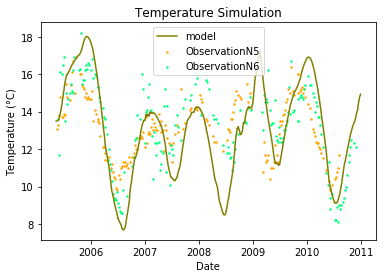

1.630080774629951 1.4430168329579527 1.5365488037939519


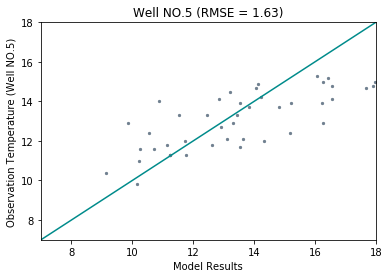

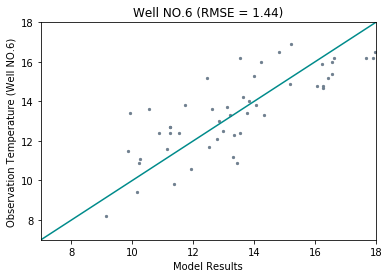

In [6]:
swt = flopy.seawat.Seawat(#modflowmodel= tm,
                          #mt3dmodel = mt, 
                          modelname= modelname,#'seawat',
                          exe_name='swt_v4', model_ws = workspace)

nrow = 1
ncol = 95
nlay = 10

Lx = 950
Ly = 1

botm = np.ones ( (nlay, nrow, ncol), dtype=np.int32 )
top = 33 * np.ones ( (nrow, ncol), dtype=np.int32 )

# Range does not include upper bound !!!
for i in range ( 30, 33):
    top[ :, i ] = 31
for i in range ( 47, 48 ):
    top[ :, i ] = 27.9
for i in range ( 50, 65):
    top[ :, i ] = 32

# N1 layer
botm[ 0, :, : ] = 28

# N2 layer46 
for i in range ( 0, 46):
    botm[ 1, :, i ] = 24
for i in range ( 46, 48 ):
    botm[ 1, :, i ] = 25
for i in range ( 48, 67 ):
    botm[ 1, :, i ] = 26
for i in range ( 67, ncol ):
    botm[ 1, :, i ] = 25
# N3 layer
for i in range ( 0, 33 ):
    botm[ 2, :, i ] = 20
for i in range ( 33, 46 ):
    botm[ 2, :, i ] = 21.5
for i in range ( 46, 48 ):
    botm[ 2, :, i ] = 24
for i in range ( 48, ncol ):
    botm[ 2, :, i ] = 24.5
# N4 layer
for i in range ( 0, 47 ):
    botm[ 3, :, i ] = 17
for i in range ( 47, 50 ):
    botm[ 3, :, i ] = 16
for i in range ( 50, 60 ):
    botm[ 3, :, i ] = 15
for i in range ( 60, ncol ):
    botm[ 3, :, i ] = 20
# N5 layer
for i in range ( 0, 50 ):
    botm[ 4, :, i ] = 15
for i in range ( 50, 60 ):
    botm[ 4, :, i ] = 14
for i in range ( 60, ncol ):
    botm[ 4, :, i ] = 16
# N6 layer
for i in range ( 0, 60 ):
    botm[ 5, :, i ] = 13
for i in range ( 60, ncol ):
    botm[ 5, :, i ] = 15
# 7 layer
botm[ 6, :, : ] = 10
# 8 layer
botm[ 7, :, : ] = 9
# 9 layer
botm[ 8, :, : ] = -12.5
# 10 layer
botm[ 9, :, : ] = -30

delr = Lx / ncol
delc = Ly / nrow
nper = 505

perlen = np.ones ( nper) * 7
perlen[0] = 1
#nstp = np.ones ( nper) * 7
#nstp[0] = 1
#print(perlen)
steady = np.full ( nper, False, dtype=bool )
steady[ 0 ] = True
dis = mf.ModflowDis(
    swt, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper,
    perlen = perlen,
    steady=steady
)

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

for i in range ( 1, nlay ):
    ibound[ i, :, 0 ] = -1
    ibound[ i, :, -1 ] = -1

for k in range ( 47, 49 ):
    ibound[ 0, :, k ] = 0

strt = np.ones ( (nlay, nrow, ncol), dtype=np.int32 ) * 27.5
#strt[ 1, :, 1 ] = 28 
#strt[ 1, :, -1 ] = 28

for i in range ( 30, 33 ):
    strt[ 0, :, i ] = 29
for j in range ( 50, 65 ):
    strt[ 0, :, j ] = 28.1
    
bas = mf.ModflowBas(swt,#tm,
                    ibound=ibound, strt=strt)

csv = pd.read_csv('SPA101-weekly.csv', delimiter=' ')
chd_values = csv.iloc[ :, 1 ].values

#chd for each cell
#   #[lay, row, col, shead, ehead]
spchd = {}
spchd[0] = [
    [1, 0, 0, 28, 28 ], 
    [1, 0, ncol-1, 28, 28 ]
]

for layer in range (2, nlay):
    spchd[0].append ([layer, 0, 0, 28, 28 ])

for stress_period in range ( 1, nper ):
    spchd[stress_period] = [[1, 0, 0, chd_values[stress_period - 1], chd_values[stress_period]]]
    for layer in range (2, nlay):
        spchd[stress_period].append ([layer, 0, 0, chd_values[stress_period-1], chd_values[stress_period]])

chd = mf.ModflowChd(swt,#tm,
                    stress_period_data=spchd)

sp = {}
sp[0] = []
bas12_data = pd.read_csv ( 'Basin1&2-weekly.csv', delimiter=' ' ).iloc[ :, 1 ].values
bas3_data = pd.read_csv ( 'Basin3-weekly.csv', delimiter=' ' ).iloc[ :, 1 ].values

for col in range ( 30, 33 ):
    sp[ 0 ].append ( [ 0, 0, col, 31, 40] )
    
for col in range ( 50, 65 ):
    sp[ 0 ].append ( [ 0, 0, col, 30, 20] )
    
for stress_period in range ( 1,  nper ):
    sp[ stress_period ] = [ ]
    for col in range ( 30, 33 ):
        sp[ stress_period ].append ( [ 0, 0, col, 29.1 + 3.5 * bas3_data[ stress_period - 1 ] , 40] )
       
    for col in range ( 50, 65 ):
        sp[ stress_period ].append ( [ 0, 0, col, 28.5 + 4 * bas12_data[ stress_period - 1 ], 20] )

ghb = mf.ModflowGhb (swt,#tm,
                     stress_period_data=sp)

# Pumping Well
wel_data = pd.read_csv('Pumping_well-weekly.csv', delimiter=' ').iloc[:, -2].values 

# -1 pumping rate of well 6
# -2 average pumping rate of well 5 and well 6

spwell = {}
spwell[0] = [8, 0, 41, 0]
for i in range(1, nper):
    spwell[i] = [8, 0, 41, -wel_data[i-1]/70]
    
wel = mf.ModflowWel(swt, stress_period_data=spwell, ipakcb=53)

k1 = 6   # fine sand 1.728-7.776
k2 = 16 # middle sand 7.776-34.56
k3 = 39  # stone 34.56-103.68
k4 = 1   # clay
k5 = 16  # middle sand2
k6 = 6   # fine sand 1.728-7.776

# Set default hk-value value to k2
hk = np.ones((nlay, nrow, ncol)) * k2

# N1 layer
hk[0, :, :] = k1  # fine sand

# N2 layer
hk[1, :, :] = k2  # middle sand

# N3 layer
for i in range( 30, 60 ):
    hk[2, :, i] = k3  # sand & stone
for i in range( 55, 67 ):
    hk[2, :, i] = k4  # clay

#  N4 layer
hk[3, :, :] = k5  # middle sand2

# N5 layer
for i in range( 30, 44 ):
    hk[4, :, i] = k3  # sand & stone
for i in range( 44, 48 ):
    hk[4, :, i] = k4  # clay
for i in range( 48, 60 ):
    hk[4, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[4, :, i] = k4  # clay

# N6 layer
hk[5, :, :] = k3
for i in range(36, 50 ):
    hk[5, :, i] = k6  # fine sand
for i in range( 50, 60 ):
    hk[5, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[5, :, i] = k4  # clay

# 7 layer
hk[6, :, :] = k5  # middle sand2

# 8 layer
hk[7, :, :] = k5
for i in range(36 , 50 ):
    hk[7, :, i] = k6  # fine sand

# 9 layer
hk[8, :, :] = k5  # middle sand2

# 10 layer
hk[9, :, :] = k5  # middle sand2


# vertical HK
vk1 = k1*0.3#3#2 #2
vk2 = k2*0.3#3#6 #6
vk3 = k3*0.3#3#10 #10
vk4 = k4*0.3#3#0.5 #0.5
vk5 = k5*0.3#3#6 #6
vk6 = k6*0.3#3#2 #2

vka = np.ones((nlay, nrow, ncol), dtype=int) * vk2

# N1 layer
vka[0, :, :] = vk1  # fine sand


# N2 layer
vka[1, :, :] = vk2  # middle sand

# N3 layer
vka[2, :, :] = vk3
for i in range( 30, 55 ):
    vka[2, :, i] = vk3  # sand & stone
for i in range( 55, 67 ):
    vka[2, :, i] = vk4  # clay

# N4 layer
vka[3, :, :] = vk5  # middle sand2

# N5 layer
for i in range( 30, 44 ):
    vka[4, :, i] = vk3  # sand & stone
for i in range( 44, 48 ):
    vka[4, :, i] = vk4  # clay
for i in range( 48, 60 ):
    vka[4, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[4, :, i] = vk4  # clay

# N6 layer
vka[5, :, :] = vk3
for i in range( 36, 50 ):
    vka[5, :, i] = vk6  # fine sand
for i in range( 50, 60 ):
    vka[5, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[5, :, i] = vk4  # clay

# N7 layer
vka[6, :, :] = vk5  # middle sand2

# N8 layer
vka[7, :, :] = vk5
for i in range( 36, 50):
    vka[7, :, i] = vk6  # fine sand

# N9 layer
vka[8, :, :] = vk5  # middle sand2

# N10 layer
vka[9, :, :] = vk5  # middle sand2

laytyp = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

sy = 0.35
ss = 1e-5

lpf = mf.ModflowLpf(swt#tm
                    , laytyp=laytyp, hk=hk, layvka=0, vka=vka, sy=sy, ss=ss, ipakcb=53)

budgetfile = '{}.cbb'.format(modelname)
budget_filerecord = [budgetfile]

oc = mf.ModflowOc(swt,#tm, 
                   save_every=True,
                   save_types=['print head', 'print budget', 'save head', 'save budget'],
                   budget_filerecord=budget_filerecord,
                   compact=True
                  )

pcg = mf.ModflowPcg (swt, rclose=1e-1)

lmt = flopy.modflow.ModflowLmt ( swt, output_file_name = modelname + '.ftl', output_file_header='extended',
                                 output_file_format='formatted')

if os.path.isfile('Basin-T-weekly.csv'):
    heat = pd.read_csv('Basin-T-weekly.csv',delimiter=' ',header = -1)
else:
    os.chdir("..")
    heat = pd.read_csv('Basin-T-weekly.csv',delimiter=' ',header = -1)

heat_basin = heat.iloc[:,-1].values
#print (heat, heat_basin)
#mt = flopy.mt3d.Mt3dms(modelname = modelname,#'heat',
#                       version='mt3dms',  exe_name='mt3dms5b', 
#                       model_ws = workspace, 
#                       modflowmodel = tm, ftlfilename = modelname + ".ftl", verbose = True)

adv = mt3.Mt3dAdv(swt, mixelm = -1, percel = 0.75)
icbund = np.ones((nlay, nrow, ncol), dtype=np.int32)
icbund[:,:,0] = -1
icbund[:,:,-1] = -1
sconc_2 = np.ones((nlay, nrow, ncol)) * 10

for i in range ( 30, 55):
    sconc_2[ :, :, i ] = 18
for i in range ( 38, 45):
    sconc_2[ :, :, i ] = 13.5
for i in range ( 30, 33):
    sconc_2[ 0, :, i] = 12
for i in range ( 50, 65):
    sconc_2[ 0, :, i] = 12
    
obs = [ ( 8, 0, 41)]

sconc_1 = np.ones((nlay, nrow, ncol))*0

btn = mt3.Mt3dBtn(swt,icbund= icbund, ncomp=2, mcomp=2, sconc = sconc_1,
                  sconc2 = sconc_2,
                  prsity = 0.35, species_names=['heat'], obs=obs,
                  nprobs=7)

dsp = mt3.Mt3dDsp(swt, al = 2, trpt= 0.1,trpv = 0.03, dmcoef= 0.13, dmcoef2 = 0)

gcg = mt3.Mt3dGcg(swt, mxiter=100,isolve = 2,cclose = 1e-2,ncrs =1)             
rct = mt3.Mt3dRct(swt,isothm=1,ireact= 0, prsity2=0.35, igetsc=0, rhob = 1.7e3, sp1= 0,
                  sp12 = 0.25e-3)

ssm_data = {}
ssm_data[0] = []

itype = flopy.mt3d.Mt3dSsm.itype_dict()

for i in range( 30, 33):
    ssm_data[0] = ssm_data[0] + [[0, 0, i, 0 , itype[ 'GHB' ],0,14]]
for i in range ( 50, 65):
    ssm_data[0].append( [ 0, 0, i, 0, itype[ 'GHB' ] ,0,14] )
    
for j in range (1,280):
    ssm_data[ j ] = [ ]
    for i in range ( 30, 33):
         ssm_data[ j ].append ( [ 0, 0, i, 0, itype[ 'GHB' ] , 0,heat_basin[ j - 1 ]])
    for i in range ( 50, 65):
         ssm_data[ j ].append ( [ 0, 0, i, 0, itype[ 'GHB' ], 0,heat_basin[ j - 1 ] ] )
for j in range(280,nper):
    ssm_data[ j ] = [ ]
    for i in range ( 30, 33):
        ssm_data[ j ].append ( [0, 0, i, 0 , itype[ 'GHB' ],0,14] )
    for i in range ( 50, 65):
        ssm_data[ j ].append ( [0, 0, i, 0 , itype[ 'GHB' ],0,14] )


ssm = flopy.mt3d.Mt3dSsm(swt, stress_period_data=ssm_data)



vdf = flopy.seawat.SeawatVdf ( swt,  mtdnconc=-1, mfnadvfd=1, nswtcpl=0,
                             iwtable=0, densemin=0.0, densemax=0.0,
                             denseref=1000, drhodprhd=0.0, prhrhd=0.0, 
                             drhodc=[0, -0.375],
                             crhoref=[0, 25],
                             nsrhoeos=2, firstdt=2 )

a = [0.00002394, 10, 248.37, 133.15]

vsc = flopy.seawat.SeawatVsc ( swt, mt3dmuflg=-1, viscmin=0, viscmax=0, nsmueos=1,
                             viscref= 0.001, mutempopt=1, mtmuspec=1,
                             dmudc=1.923e-6, mtmutempspec=2, amucoeff=a)
swt.write_input()
swt.run_model(silent = True)

if os.path.isfile('MT3D002.OBS'):
    t = pd.read_csv('MT3D002.OBS',delimiter=' ', nrows=820,skiprows=[0,1],skipinitialspace=True,skip_blank_lines=True,usecols=[1,2],index_col=0)
else:
    os.chdir(workspace)
    t = pd.read_csv('MT3D002.OBS',delimiter=' ', nrows=820,skiprows=[0,1],skipinitialspace=True,skip_blank_lines=True,usecols=[1,2],index_col=0)

if os.path.isfile('N5_T.csv'):
    n = pd.read_csv('N5_T.csv',delimiter=',',header=0,skip_blank_lines=True,index_col=0)
    w = pd.read_csv('N6_T.csv',delimiter=',',header=0, index_col=0)
else:
    os.chdir("..")
    n = pd.read_csv('N5_T.csv',delimiter=',',header=0,skip_blank_lines=True,index_col=0)
    w = pd.read_csv('N6_T.csv',delimiter=',',header=0 ,index_col=0)


t1 = t.index.values
y1 = []
for i in t1:
    y1.append([datetime.date(2005,5,11)+datetime.timedelta(i-1)])
t2 = t.iloc[:,0].values


n1 = n.index.values
y2 = []
for i in n1:
    y2.append([datetime.date(2005,5,11)+datetime.timedelta(np.float64(i-1))])
n2 = n.iloc[:,0].values

w1 = w.index.values
y3 = []
for i in w1:
    y3.append([datetime.date(2005,5,11)+datetime.timedelta(np.float64(i-1))])
w2 = w.iloc[:,0].values

plt.plot(y1,t2,c='olive')
plt.scatter(y2,n2,c='orange',s=2)
plt.scatter(y3,w2,c='springgreen',s=2)
plt.legend(['model','ObservationN5','ObservationN6'])
plt.xlabel ( 'Date' )
plt.ylabel ( 'Temperature (°C)' )
plt.title('Temperature Simulation')
#plt.savefig('temperature.png')
plt.show()
plt.close()

x = t.join(n, how='inner')
v1 = x.iloc[:,0].values
v2 = x.iloc[:,1].values
rmse1 =  math.sqrt ( mse ( v1, v2 ) )

x = t.join(w, how='inner')
v1=x.iloc[:,0].values
v2 = x.iloc[:,1].values
rmse2 =  math.sqrt ( mse ( v1, v2 ) )
rmse = (rmse1 + rmse2)/2
print (rmse1,rmse2,rmse)

x = t.join(n, how='inner')
v1 = x.iloc[:,0].values
v2 = x.iloc[:,1].values
x1 = [7,18]
y1 = [7,18]
plt.scatter(v1,v2,s = 5,c='slategray')
plt.plot(x1,y1,c='darkcyan')
plt.ylim(7,18)
plt.xlim(7,18)
plt.xlabel ( 'Model Results' )
plt.ylabel ( 'Observation Temperature (Well NO.5)' )
rmse =  math.sqrt ( mse ( v1, v2 ) )
rmse = '{:01.2f}'.format(rmse)
plt.title('Well NO.5 (RMSE = ' + str (rmse)+')')
plt.show()
plt.close()


x = t.join(w, how='inner')
v1=x.iloc[:,0].values
v2 = x.iloc[:,1].values
x = [7,18]
y = [7,18]
plt.scatter(v1,v2,s = 5,c='slategray')
plt.plot(x,y,c='darkcyan')
plt.ylim(7,18)
plt.xlim(7,18)
plt.xlabel ( 'Model Results' )
plt.ylabel ( 'Observation Temperature (Well NO.6)' )
rmse =  math.sqrt ( mse ( v1, v2 ) )
rmse = '{:01.2f}'.format(rmse)
plt.title('Well NO.6 (RMSE = ' + str (rmse)+')')
plt.show()
plt.close()